### Supported MealPy version 2.5.4
!  pip install mealpy==2.5.4

In [ ]:
import numpy as np
from mealpy.optimizer import Optimizer

### Optimizer

In [ ]:
class ACSA(Optimizer):

    def __init__(self, epoch=10000, pop_size=100, eh=0.66, en=1.8, sh=0.33, sn=0.002, nh_rate=0.1, scale=0.01, **kwargs):

        super().__init__(**kwargs)
        self.epoch = self.validator.check_int("epoch", epoch, [1, 100000])
        self.pop_size = self.validator.check_int("pop_size", pop_size, [10, 10000])
        self.eh = self.validator.check_float("eh", eh, (0.1, 1.6))
        self.en = self.validator.check_float("en", en, (1.7, 3.2))
        self.sh = self.validator.check_float("sh", sh, (0.1, 0.5))
        self.sn = self.validator.check_float("sn", sn, [0.001, 0.003])
        self.nh_rate = self.validator.check_float("nh_rate", nh_rate, [0.1, 0.9])
        self.scale = self.validator.check_float("scale", scale, [0.001, 0.5])
        self.set_parameters(["epoch", "pop_size", "eh", "en", "sh", "sn"])
        self.sort_flag = False

    def before_main_loop(self):

        # Nervous Regulator Size
        self.Nsize = int(np.round(self.pop_size * self.nh_rate))

        # Sorted Population and Global Best
        self.pop_elites, self.g_best = self.get_global_best_solution(self.pop)

        # Mean value of population
        pop_list = np.array([regulator[self.ID_POS] for regulator in self.pop])
        self.mean_pop = np.mean(pop_list, axis=0)
        self.mean_pop = self.amend_position(self.mean_pop, self.problem.lb, self.problem.ub)

        # Boundary of Solutions
        self.boundary = self.scale * (self.problem.ub - self.problem.lb)

    def stimulation_function(self, x_vector=None, regulator=None):

        if regulator=="nervous":
            innervation = self.boundary / (1 + np.exp(self.en * (-(x_vector) + self.sn)))

        elif regulator=="hormonal":
            innervation = self.boundary / (1 + np.exp(self.eh * (-(x_vector) + self.sh)))

        else:
            print("Error: Check your regulator.")

        return innervation


    def evolve(self, epoch):

        pop_new = []
        self.sorted_pop = self.pop_elites[::-1]

        for idx in range(0, self.pop_size):

            if idx < self.Nsize:

                pos_new = self.stimulation_function((self.sorted_pop[idx][self.ID_POS]), regulator="nervous")

            else:

                if np.random.rand() < 0.5:

                    pos_new = self.mean_pop[self.ID_POS] + np.random.randn() * self.stimulation_function((self.sorted_pop[idx][self.ID_POS]), regulator="hormonal")

                else:

                    pos_new = self.g_best[self.ID_POS] + np.random.randn() * (self.mean_pop[self.ID_POS] - self.sorted_pop[idx][self.ID_POS])



            pos_new = self.amend_position(pos_new, self.problem.lb, self.problem.ub)
            pop_new.append([pos_new, None])

            if self.mode not in self.AVAILABLE_MODES:
                target = self.get_target_wrapper(pos_new)
                self.pop[idx] = self.get_better_solution(self.pop[idx], [pos_new, target])

        if self.mode in self.AVAILABLE_MODES:
            pop_new = self.update_target_wrapper_population(pop_new)
            self.pop = self.greedy_selection_population(self.pop, pop_new)

### Define Problems

In [ ]:
# Basic Benchmark Function
def function(solution):
    return np.sum(solution**2)

In [ ]:
problem = {
    "fit_func": function,
    "lb": [-3, 0, -3, -5.7, -3.1],
    "ub": [2.5, 5, 2, 5.9, 1.5],
    "minmax": "min",
}

### Define Parameters of ACSA

In [ ]:
eh = 0.6
en = 1.8
sh = 0.3
sn = 0.002
nh_rate=0.2
scale=0.1

epoch = 100
pop_size = 300

In [ ]:
model = ACSA(epoch, pop_size, eh, en, sh, sn, nh_rate, scale)
best_position, best_fitness = model.solve(problem)
print(f"Solution: {best_position}, Fitness: {best_fitness}")

### Global Best

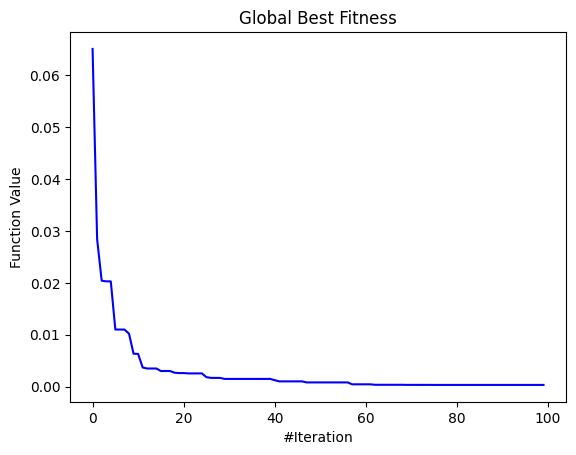

In [ ]:
model.history.save_global_best_fitness_chart()

### Diversity Chart

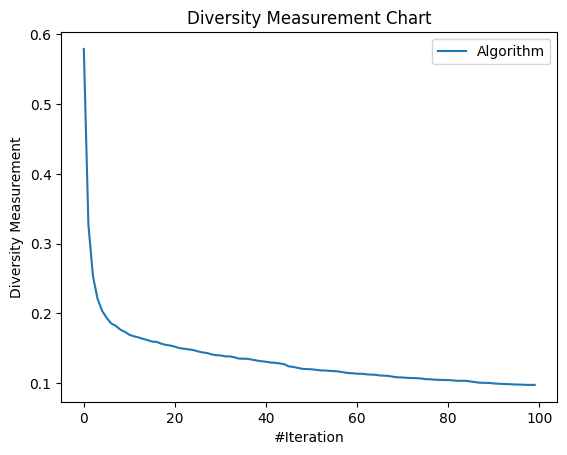

In [ ]:
model.history.save_diversity_chart()

### Runtime Chart

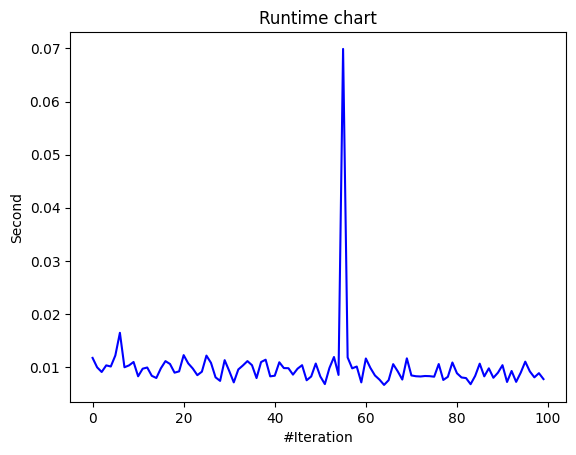

In [ ]:
model.history.save_runtime_chart()

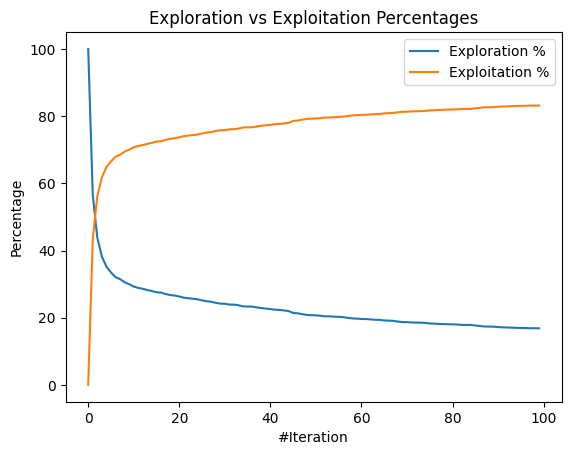

In [ ]:
model.history.save_exploration_exploitation_chart()